Study local 3D scale in different cell types of Larval zebrafish.

# Packages importation and general configuration

In [1]:
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interpolate
from skimage import measure

import nrrd

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d

sys.setrecursionlimit(10**7)

In [2]:
from genepy3d.io import swc
from genepy3d.obj import curves, trees, points, surfaces
from genepy3d.util import geo, plot as mypl

In [3]:
%matplotlib notebook

# Setting scale range

The maximal scale (rmax) is defined based on the length of the largest branch region in dataset (i.e; rmax = 1/3 * 300 microns).

In [4]:
rmin, rmax = 1, 102
r_lst = np.arange(rmin,rmax,5)
print("list of scales:",r_lst)

list of scales: [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101]


# Loading annotated brain region

In [5]:
regions, _ = nrrd.read('../data/zebrafish/MPIN-Atlas__brain_region__Combined_brain_regions/MPIN-Atlas__brain_region__Combined_brain_regions.nrrd')
regions = np.swapaxes(regions,0,2)
print('shape (Z, Y, X):',regions.shape)
maxlbl = np.max(regions)
clcs = np.random.rand(maxlbl,3)
print('max region id:',maxlbl)

shape (Z, Y, X): (359, 974, 597)
max region id: 36


In [6]:
region_csv = pd.read_csv("../data/zebrafish/MPIN-Atlas__brain_region__Combined_brain_regions/MPIN-Atlas__brain_region__Combined_brain_regions_index_refined.csv")
region_csv.head()

Grey_level                  Brain_region  norm_strength  Abbr
0           1  Medial_octavolateral_nucleus      22.454680   MON
1           2                    Cerebellum      38.791980    Cb
2           3                   MO_stripe_1      26.976780  MOS1
3           4                   MO_stripe_2       0.291515  MOS2
4           5                   MO_stripe_3      14.606526  MOS3

# Retina Ganglion cells

## Loading results

In [7]:
filelist = glob.glob("../data/zebrafish/cell_types/retina/*.csv")
done_neuidlst = np.array([int(item.split("retina")[2].split(".csv")[0]) for item in filelist])
print("nb. of computed neurons:",len(done_neuidlst))
print(done_neuidlst)

nb. of computed neurons: 42
[38 26 21 16 29 13 10 35 33 31 27  4 19 23  0  1  9  5 12 37 41 25 14 40
 18 32 30 24 36 11  3 39 15 17  2 34 20  7 22  6 28  8]


## Plots

### 3D plots

#### Mean local 3d scales

<IPython.core.display.Javascript object>


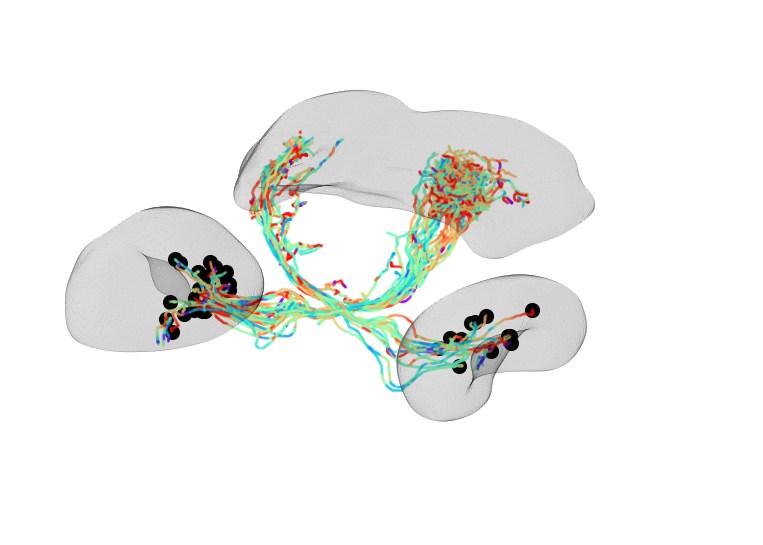

In [10]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
left_neuidlst = []
step_size = 1

for neuid in done_neuidlst:
    
    neuron = np.load("../data/zebrafish/cell_types/retina/retina{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

    left_neuidlst.append(neuid)

    df = pd.read_csv("../data/zebrafish/cell_types/retina/retina{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    meandf = subdf.groupby("nodeid")["local_scale"].mean()

    coors = neuron.get_coordinates(meandf.index.values).values
    xcoors = xcoors + coors[:,0].tolist()
    ycoors = ycoors + coors[:,1].tolist()
    zcoors = zcoors + coors[:,2].tolist()

    pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=meandf.values.flatten(),
                    s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)

    ax.plot(rootcoors[:,0],
        rootcoors[:,1],
        rootcoors[:,2],'o',
        c="black",ms=10,markeredgewidth=0.,alpha=1)

# retina
region_id = 28
halfreg = regions.copy()
# halfreg[:,:,300:]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'gray','alpha':0.1});

# tectum
region_id = 30
halfreg = regions.copy()
# halfreg[:,:,:300]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'gray','alpha':0.1});

para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
# ax.view_init(azim=0,elev=90)
ax.axis("off");
        
plt.tight_layout();

#### Std local 3d scales

<IPython.core.display.Javascript object>


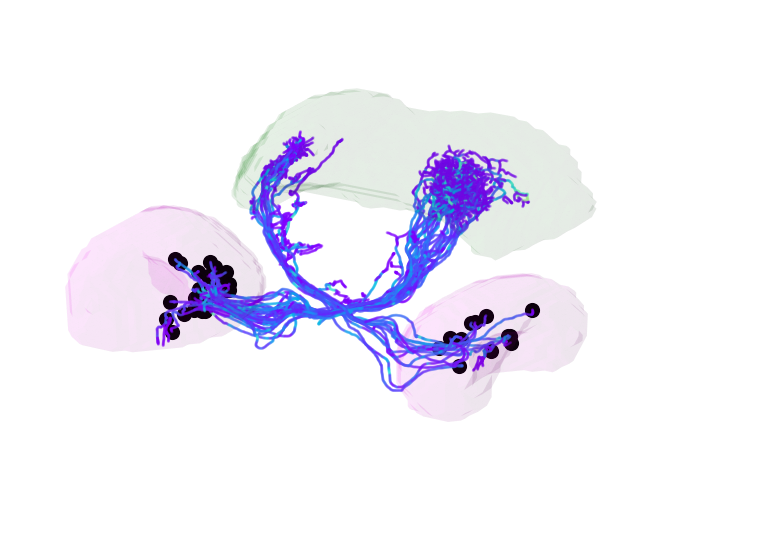

In [11]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

xcoors, ycoors, zcoors = [], [], []
left_neuidlst = []
step_size = 10

for neuid in done_neuidlst:
    
    neuron = np.load("../data/zebrafish/cell_types/retina/retina{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

    left_neuidlst.append(neuid)

    df = pd.read_csv("../data/zebrafish/cell_types/retina/retina{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    meandf = subdf.groupby("nodeid")["local_scale"].std()
    meandf.fillna(0,inplace=True)

    coors = neuron.get_coordinates(meandf.index.values).values
    xcoors = xcoors + coors[:,0].tolist()
    ycoors = ycoors + coors[:,1].tolist()
    zcoors = zcoors + coors[:,2].tolist()

    pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=meandf.values.flatten(),
                    s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)

    ax.plot(rootcoors[:,0],
        rootcoors[:,1],
        rootcoors[:,2],'o',
            c="black",ms=10,markeredgewidth=0.,alpha=1)

# retina
region_id = 28
halfreg = regions.copy()
# halfreg[:,:,300:]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'magenta','alpha':0.05});

# tectum
region_id = 30
halfreg = regions.copy()
# halfreg[:,:,:300]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'green','alpha':0.05});

para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
# ax.view_init(azim=0,elev=90)
ax.axis("off");
        
plt.tight_layout();

### 2D plots

#### Left retina

<IPython.core.display.Javascript object>


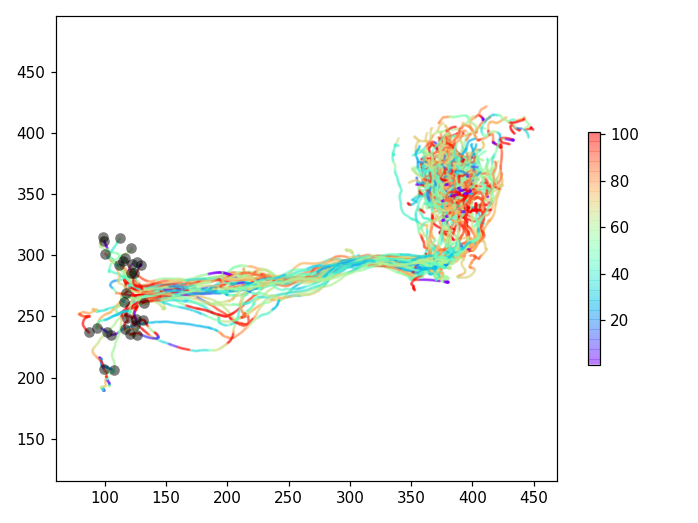

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
cbarflag = False

for neuid in done_neuidlst:
    
    neuron = np.load("../data/zebrafish/cell_types/retina/retina{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    if rootcoors[0,0] < 300:
    
        ax.plot(rootcoors[:,0],
                rootcoors[:,1],
                'o',c="black",ms=7,markeredgewidth=0.,alpha=0.5)
        
        root_coors_int = rootcoors.flatten().astype(np.int)
        root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
        
        leaf_id = np.array(neuron.get_leaves())
        leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
        leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
        leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

        df = pd.read_csv("../data/zebrafish/cell_types/retina/retina{}.csv".format(neuid))
        df.set_index("nodeid",inplace=True)
        subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
        meandf = subdf.groupby("nodeid")["local_scale"].mean()
        
        coors = neuron.get_coordinates(meandf.index.values).values
        pl = ax.scatter(coors[:,0],coors[:,1],c=meandf.values.flatten(),
                        s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)
        
        if cbarflag==False:
            fig.colorbar(pl,shrink=0.5);
            cbarflag = True

ax.axis("equal");
plt.tight_layout();

In [13]:
def check_lposition(x,y):
    """Check if the position (x,y) is within studied regions.
    """
    
    # define region border
    retina = [50,170,150,360]
    retina_exit = [180,235,150,360]
    crossing = [270,315,150,360]
    tectum_entrance = [350,450,310,340]
    tectum = [350,450,340,450]
    
    retina_ix = np.argwhere((x>=retina[0])&(x<retina[1])&(y>=retina[2])&(y<retina[3])).flatten()
    retina_exit_ix = np.argwhere((x>=retina_exit[0])&(x<retina_exit[1])&(y>=retina_exit[2])&(y<retina_exit[3])).flatten()
    crossing_ix = np.argwhere((x>=crossing[0])&(x<crossing[1])&(y>=crossing[2])&(y<crossing[3])).flatten()
    tectum_entrance_ix = np.argwhere((x>=tectum_entrance[0])&(x<tectum_entrance[1])&(y>=tectum_entrance[2])&(y<tectum_entrance[3])).flatten()
    tectum_ix = np.argwhere((x>=tectum[0])&(x<tectum[1])&(y>=tectum[2])&(y<tectum[3])).flatten()
    
    return (retina_ix,retina_exit_ix,crossing_ix,tectum_entrance_ix,tectum_ix)

#### Right retina

<IPython.core.display.Javascript object>


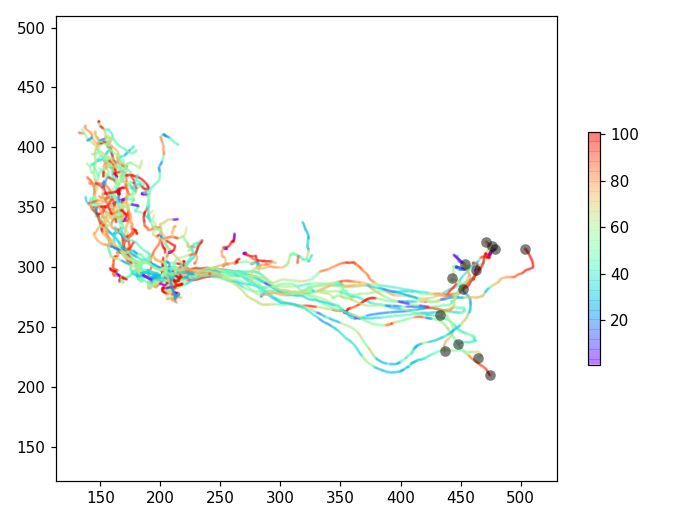

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
cbarflag = False

for neuid in done_neuidlst:
    
    neuron = np.load("../data/zebrafish/cell_types/retina/retina{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    if rootcoors[0,0] >= 300:
    
        ax.plot(rootcoors[:,0],
                rootcoors[:,1],
                'o',c="black",ms=7,markeredgewidth=0.,alpha=0.5)
        
        root_coors_int = rootcoors.flatten().astype(np.int)
        root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
        
        leaf_id = np.array(neuron.get_leaves())
        leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
        leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
        leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

        df = pd.read_csv("../data/zebrafish/cell_types/retina/retina{}.csv".format(neuid))
        df.set_index("nodeid",inplace=True)
        subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
        meandf = subdf.groupby("nodeid")["local_scale"].mean()
        
        coors = neuron.get_coordinates(meandf.index.values).values
        pl = ax.scatter(coors[:,0],coors[:,1],c=meandf.values.flatten(),
                        s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)
        
        if cbarflag==False:
            fig.colorbar(pl,shrink=0.5);
            cbarflag = True

ax.axis("equal");
plt.tight_layout();

In [15]:
def check_rposition(x,y):
    """Check if the position (x,y) is within studied regions.
    """
    
    retina = [400,550,150,360]
    retina_exit = [335,375,150,360]
    crossing = [260,300,250,300]
    tectum_entrance = [160,250,280,320]
    tectum = [100,250,330,450]
    
    retina_ix = np.argwhere((x>=retina[0])&(x<retina[1])&(y>=retina[2])&(y<retina[3])).flatten()
    retina_exit_ix = np.argwhere((x>=retina_exit[0])&(x<retina_exit[1])&(y>=retina_exit[2])&(y<retina_exit[3])).flatten()
    crossing_ix = np.argwhere((x>=crossing[0])&(x<crossing[1])&(y>=crossing[2])&(y<crossing[3])).flatten()
    tectum_entrance_ix = np.argwhere((x>=tectum_entrance[0])&(x<tectum_entrance[1])&(y>=tectum_entrance[2])&(y<tectum_entrance[3])).flatten()
    tectum_ix = np.argwhere((x>=tectum[0])&(x<tectum[1])&(y>=tectum[2])&(y<tectum[3])).flatten()
    
    return (retina_ix,retina_exit_ix,crossing_ix,tectum_entrance_ix,tectum_ix)

## Local 3D scales across regions

In [16]:
cell_groups = ["retina","retina \n exit","crossing","tectum \n entrance","tectum"]
val, lbl = [], []
for neuid in done_neuidlst:
    neuron = np.load("../data/zebrafish/cell_types/retina/retina{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]

    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

    df = pd.read_csv("../data/zebrafish/cell_types/retina/retina{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    meandf = subdf.groupby("nodeid")["local_scale"].mean()

    coors = neuron.get_coordinates(meandf.index.values).values
    x = coors[:,0]
    y = coors[:,1]
    ls = meandf.values.flatten()
    
    if rootcoors[0,0] < 300:
        ids_groups = check_lposition(x,y)
    else:
        ids_groups = check_rposition(x,y)
    
    for i in range(len(ids_groups)):
        if len(ids_groups[i])!=0:
            val.append(np.mean(ls[ids_groups[i]]))
            lbl.append(cell_groups[i])

df = pd.DataFrame({"region":lbl,"mean_local_3D_scale":val})

<IPython.core.display.Javascript object>


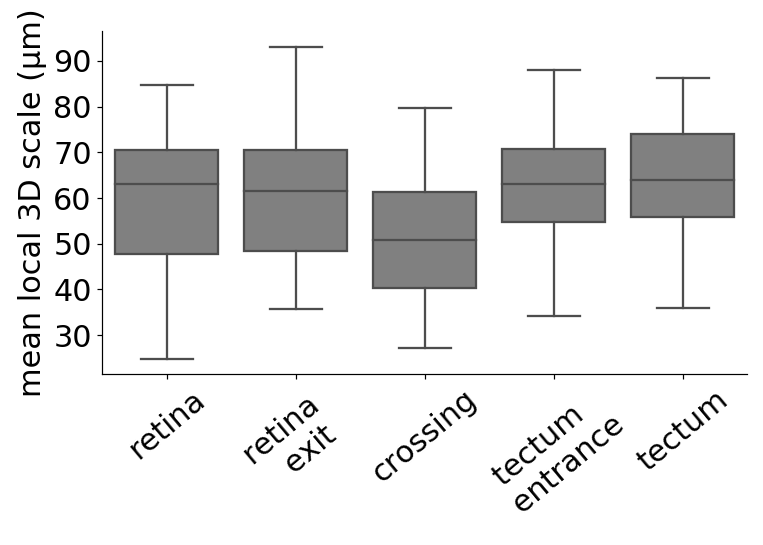

In [17]:
siz=20
fig,ax = plt.subplots(1,1,figsize=(7,5))
pl = sns.boxplot(x="region",y="mean_local_3D_scale",data=df,order=cell_groups,color="gray");
ax.set_xlabel("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,fontsize=siz);
plt.tight_layout();
ax.set_yticklabels(ax.get_yticklabels(),fontsize=siz)
ax.set_ylabel("mean local 3D scale (µm)",fontsize=siz)
plt.tight_layout();

In [18]:
# one-way anova
model = ols('mean_local_3D_scale ~ C(region)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq     df         F    PR(>F)
C(region)   3857.224471    4.0  4.924114  0.000826
Residual   39754.184311  203.0       NaN       NaN


In [19]:
# multiple comparison
m_comp = pairwise_tukeyhsd(endog=df['mean_local_3D_scale'], groups=df['region'], alpha=0.05)
m_comp.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

# Mitral cells

## Loading computed neurons

In [21]:
filelist = glob.glob("../data/zebrafish/cell_types/mitral/*.csv")
done_neuidlst = np.array([int(item.split("mitral")[2].split(".csv")[0]) for item in filelist])
print("nb. of computed neurons:",len(done_neuidlst))
print(done_neuidlst)

nb. of computed neurons: 55
[ 0 21 12 52 15 47 14  2 40 26 38 28 34 10 33 46 51  4 13  1  6 43 54 32
 27 24 25 23 30 37 53 35 22 19 42 41 44 39  9 45  3 50 16  5 49  8 17 31
 48 11 29  7 18 20 36]


## Plots

### 3D plots

#### Mean local 3d scales

<IPython.core.display.Javascript object>


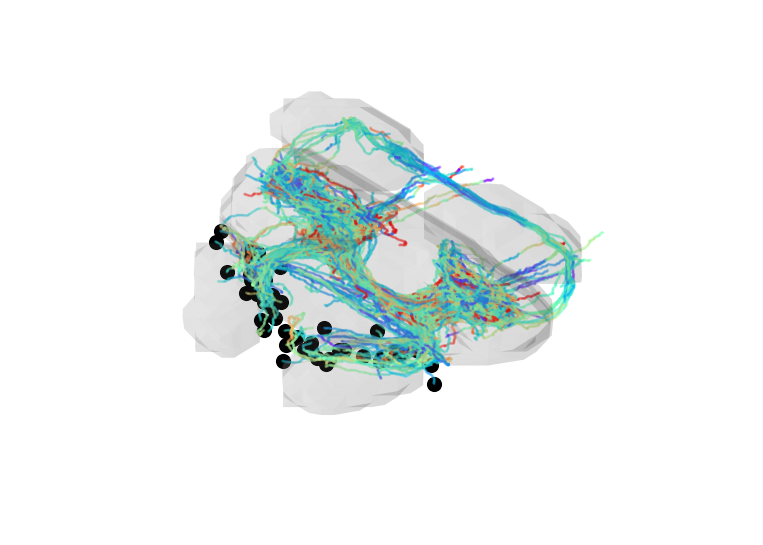

In [22]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

step_size = 10
xcoors, ycoors, zcoors = [], [], []
half_neuidlst = []
for neuid in done_neuidlst:
    
    neuron = np.load("../data/zebrafish/cell_types/mitral/mitral{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
        
    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

    half_neuidlst.append(neuid)

    df = pd.read_csv("../data/zebrafish/cell_types/mitral/mitral{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    meandf = subdf.groupby("nodeid")["local_scale"].mean()

    coors = neuron.get_coordinates(meandf.index.values).values
    xcoors = xcoors + coors[:,0].tolist()
    ycoors = ycoors + coors[:,1].tolist()
    zcoors = zcoors + coors[:,2].tolist()

    pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=meandf.values.flatten(),
                    s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)

    ax.plot(rootcoors[:,0],
        rootcoors[:,1],
        rootcoors[:,2],'o',
        c="black",ms=10,markeredgewidth=0.,alpha=1)

# olfactory 
region_id = 21
halfreg = regions.copy()
# halfreg[:,:,300:]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'gray','alpha':0.1});
        
# pallium of cerebellum
region_id = 23
halfreg = regions.copy()
# halfreg[:,:,300:]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'gray','alpha':0.1});

# subpallium of cerebellum
# region_id = 29
# halfreg = regions.copy()
# # halfreg[:,:,300:]=0
# surf = surfaces.Surface.from_volume(halfreg,level=region_id,spacing=(1,1,1),step_size=step_size)
# surf.plot(ax,args_3d={'color':'blue','alpha':0.1});

# habenula
region_id = 17
halfreg = regions.copy()
# halfreg[:,:,:300]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'gray','alpha':0.1});
        
para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
ax.view_init(azim=-45,elev=60)
# ax.view_init(azim=0,elev=90);
# ax.view_init(azim=-90,elev=0);
ax.axis("off");
        
plt.tight_layout();

#### Std local 3d scales

<IPython.core.display.Javascript object>


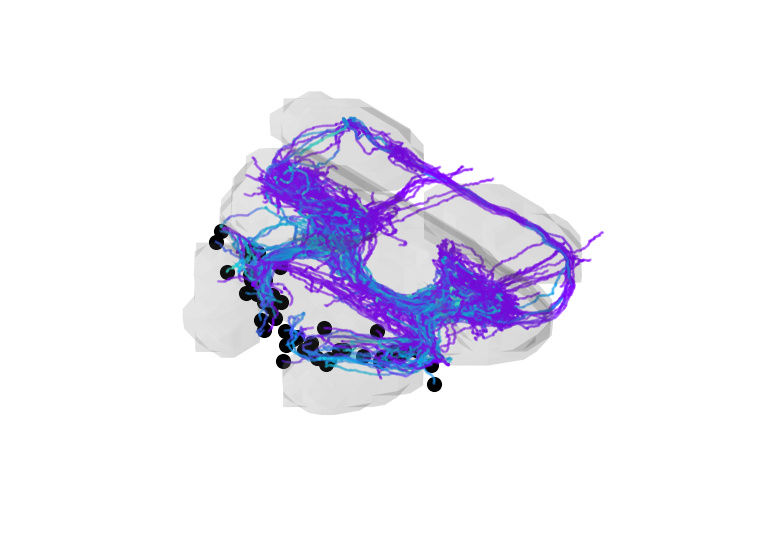

In [25]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

step_size = 10
xcoors, ycoors, zcoors = [], [], []
half_neuidlst = []
for neuid in done_neuidlst:
    
    neuron = np.load("../data/zebrafish/cell_types/mitral/mitral{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

    half_neuidlst.append(neuid)

    df = pd.read_csv("../data/zebrafish/cell_types/mitral/mitral{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    meandf = subdf.groupby("nodeid")["local_scale"].std()
    meandf.fillna(0,inplace=True)

    coors = neuron.get_coordinates(meandf.index.values).values
    xcoors = xcoors + coors[:,0].tolist()
    ycoors = ycoors + coors[:,1].tolist()
    zcoors = zcoors + coors[:,2].tolist()

    pl = ax.scatter(coors[:,0],coors[:,1],coors[:,2],c=meandf.values.flatten(),
                    s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)

    ax.plot(rootcoors[:,0],
        rootcoors[:,1],
        rootcoors[:,2],'o',
        c="black",ms=10,markeredgewidth=0.,alpha=1)

# olfactory 
region_id = 21
halfreg = regions.copy()
# halfreg[:,:,300:]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'gray','alpha':0.1});
        
# pallium of cerebellum
region_id = 23
halfreg = regions.copy()
# halfreg[:,:,300:]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'gray','alpha':0.1});

# subpallium of cerebellum
# region_id = 29
# halfreg = regions.copy()
# # halfreg[:,:,300:]=0
# surf = surfaces.Surface.from_volume(halfreg,level=region_id,spacing=(1,1,1),step_size=step_size)
# surf.plot(ax,args_3d={'color':'blue','alpha':0.1});

# habenula
region_id = 17
halfreg = regions.copy()
# halfreg[:,:,:300]=0
surf = surfaces.Surface.from_volume(halfreg,lbl=region_id,spacing=(1,1,1),step_size=step_size)
surf.plot(ax,args_3d={'color':'gray','alpha':0.1});
        
para = mypl.fix_equal_axis(np.array([xcoors,ycoors,zcoors]).T)
ax.set_xlim(para["xmin"],para["xmax"]);
ax.set_ylim(para["ymin"],para["ymax"]);
ax.set_zlim(para["zmin"],para["zmax"]);
ax.view_init(azim=-45,elev=60)
# ax.view_init(azim=0,elev=90);
# ax.view_init(azim=-90,elev=0);
ax.axis("off");
        
plt.tight_layout();

## 2D plots

<IPython.core.display.Javascript object>


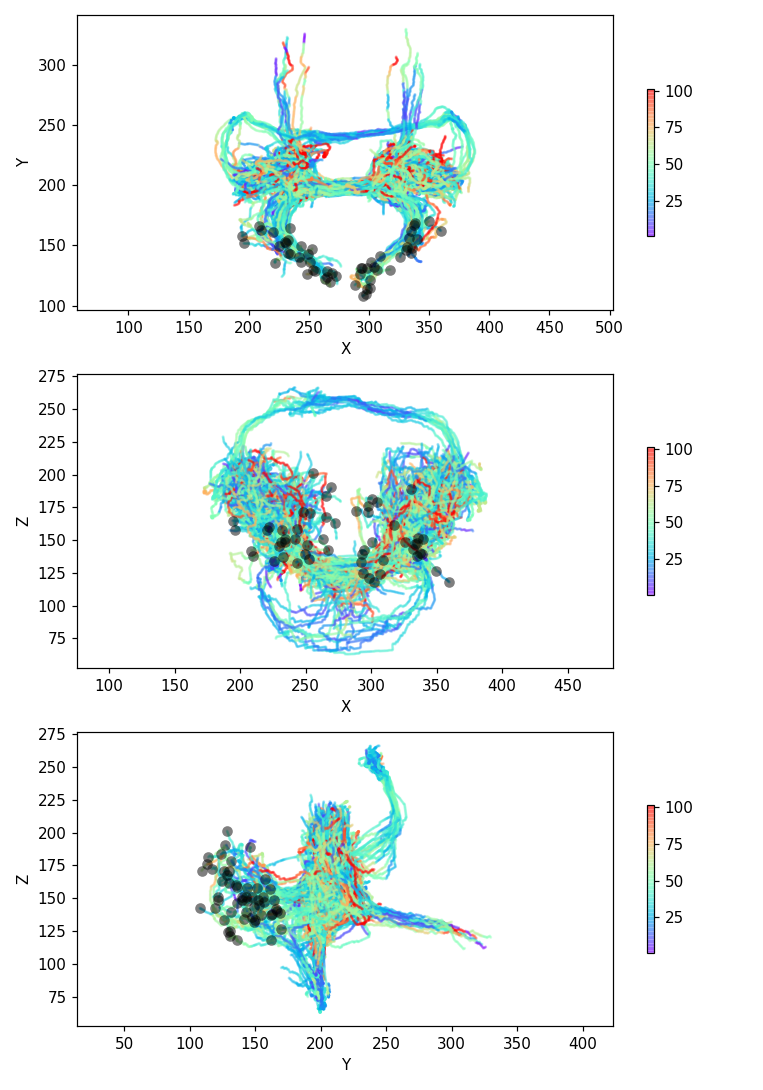

In [24]:
fig = plt.figure(figsize=(7,10))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

cbarflag1, cbarflag2, cbarflag3 = False, False, False

for neuid in done_neuidlst:
    
    neuron = np.load("../data/zebrafish/cell_types/mitral/mitral{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values
    
    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]

    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

    df = pd.read_csv("../data/zebrafish/cell_types/mitral/mitral{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    meandf = subdf.groupby("nodeid")["local_scale"].mean()
    
    coors = neuron.get_coordinates(meandf.index.values).values

    ax1.plot(rootcoors[:,0],
            rootcoors[:,1],
            'o',c="black",ms=7,markeredgewidth=0.,alpha=0.5)
    pl1 = ax1.scatter(coors[:,0],coors[:,1],c=meandf.values.flatten(),
                    s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)
    if cbarflag1==False:
        fig.colorbar(pl1,ax=ax1,shrink=0.5);
        cbarflag1 = True
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")

    ax2.plot(rootcoors[:,0],
            rootcoors[:,2],
            'o',c="black",ms=7,markeredgewidth=0.,alpha=0.5)
    pl2 = ax2.scatter(coors[:,0],coors[:,2],c=meandf.values.flatten(),
                    s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)
    if cbarflag2==False:
        fig.colorbar(pl2,ax=ax2,shrink=0.5);
        cbarflag2 = True
    ax2.set_xlabel("X")
    ax2.set_ylabel("Z")

    ax3.plot(rootcoors[:,1],
            rootcoors[:,2],
            'o',c="black",ms=7,markeredgewidth=0.,alpha=0.5)
    pl3 = ax3.scatter(coors[:,1],coors[:,2],c=meandf.values.flatten(),
                    s=1,cmap="rainbow",vmin=r_lst[0],vmax=r_lst[-1],alpha=0.3)
    if cbarflag3==False:
        fig.colorbar(pl3,ax=ax3,shrink=0.5);
        cbarflag3 = True
    ax3.set_xlabel("Y")
    ax3.set_ylabel("Z")

ax1.axis("equal");
ax2.axis("equal");
ax3.axis("equal");
plt.tight_layout();

## Local 3D scales across regions

In [26]:
def check_position(x,y,z):
    """Check if the position (x,y,z) is within the studied regions.
    """
    
    # define region border
    obl = [280,380,100,140,100,225]
    obr = [150,280,100,140,100,225]
    tell = [290,370,190,230,145,220]
    telr = [185,270,190,230,145,220]
    ac1 = [270,290,190,210,110,135]
    ac2 = [200,350,165,210,60,110]
    hc = [250,310,235,250,225,275]
    hbl = [310,385,245,275,230,275]
    hbr = [165,250,245,275,230,275]
    
    ids = []
    for item in [obl,obr,tell,telr,ac1,ac2,hc,hbl,hbr]:
        ids.append(np.argwhere((x>=item[0])&(x<item[1])&
                               (y>=item[2])&(y<item[3])&
                               (z>=item[4])&(z<item[5])).flatten())
    
    return ids

In [27]:
cell_groups = ["olfactory \n bulb","olfactory \n bulb",
               "pallium","pallium",
               "subpallium","subpallium",
               "habenula","habenula","habenula"]
val, lbl = [], []
for neuid in done_neuidlst:
    neuron = np.load("../data/zebrafish/cell_types/localfiles/mitral/mitral{}.npy".format(neuid),allow_pickle=True).item()
    rootcoors = neuron.get_coordinates(neuron.get_root()).values

    root_coors_int = rootcoors.flatten().astype(np.int)
    root_reg_lbl = regions[root_coors_int[2],root_coors_int[1],root_coors_int[0]]
    
    leaf_id = np.array(neuron.get_leaves())
    leaf_coors = neuron.get_coordinates(leaf_id).values.astype(np.uint)
    leaf_reg_lbl = regions[leaf_coors[:,2],leaf_coors[:,1],leaf_coors[:,0]]
    leaf_reg_lbl_valid = leaf_id[leaf_reg_lbl!=root_reg_lbl]

    df = pd.read_csv("../data/zebrafish/cell_types/localfiles/mitral/mitral{}.csv".format(neuid))
    df.set_index("nodeid",inplace=True)
    subdf = df[df["seg_key"].isin(leaf_reg_lbl_valid)]
    meandf = subdf.groupby("nodeid")["local_scale"].mean()

    coors = neuron.get_coordinates(meandf.index.values).values
    x = coors[:,0]
    y = coors[:,1]
    z = coors[:,2]
    ls = meandf.values.flatten()

    ids_groups = check_position(x,y,z)
    for i in range(len(ids_groups)):
        if len(ids_groups[i])!=0:
            val.append(np.mean(ls[ids_groups[i]]))
            lbl.append(cell_groups[i])

df = pd.DataFrame({"region":lbl,"mean_local_3D_scale":val})

<IPython.core.display.Javascript object>


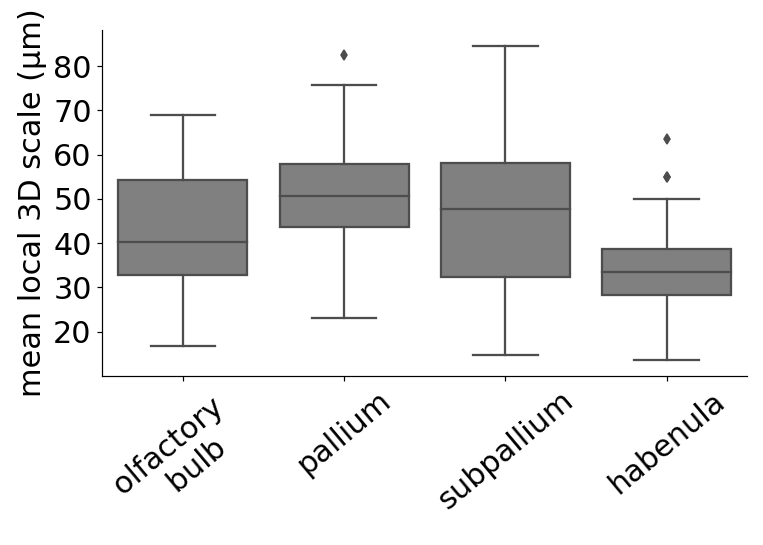

In [28]:
siz=20
fig,ax = plt.subplots(1,1,figsize=(7,5))
# pl = sns.barplot(x="region",y="mean_local_3D_scale",data=df,color="gray",order=["olfactory \n bulb","pallium","subpallium","habenula"],ci='sd',capsize=0.1);
pl = sns.boxplot(x="region",y="mean_local_3D_scale",data=df,color="gray",order=["olfactory \n bulb","pallium","subpallium","habenula"]);
ax.set_xlabel("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,fontsize=siz);
plt.tight_layout();
ax.set_yticklabels(ax.get_yticklabels(),fontsize=siz)
ax.set_ylabel("mean local 3D scale (µm)",fontsize=siz)
plt.tight_layout();

In [29]:
# one-way anova
model = ols('mean_local_3D_scale ~ C(region)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq     df          F        PR(>F)
C(region)   7670.371431    3.0  14.900728  6.097156e-09
Residual   42039.132936  245.0        NaN           NaN


In [30]:
m_comp = pairwise_tukeyhsd(endog=df['mean_local_3D_scale'], groups=df['region'], alpha=0.05)
m_comp.summary()

<class 'statsmodels.iolib.table.SimpleTable'>